C:\Users\sunfr\AppData\Local\Temp\ipykernel_32912\1262826680.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = read("input2.wav")


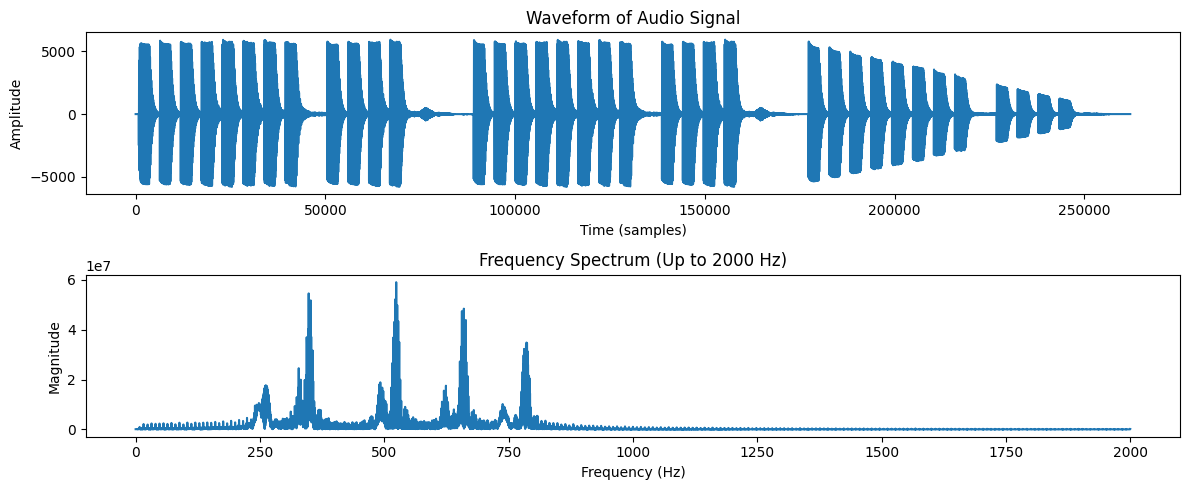

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d

sample_rate, audio = read("input2.wav")

# Convert to mono if stereo
if len(audio.shape) > 1:
    audio = audio[:, 0]


#manually add noise

noise_intensity = 5000  
noise = np.random.normal(0, noise_intensity, audio.shape)

noisy_audio = np.int16(audio + noise)

write("noisy_audio.wav", sample_rate, noisy_audio)


N = len(audio)
audio_segment = audio[:N]

fft_result = fft(audio_segment)
frequencies = np.fft.fftfreq(N, d=1/sample_rate)

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(audio_segment)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum (Up to 2000 Hz)")
plt.tight_layout()
plt.show()


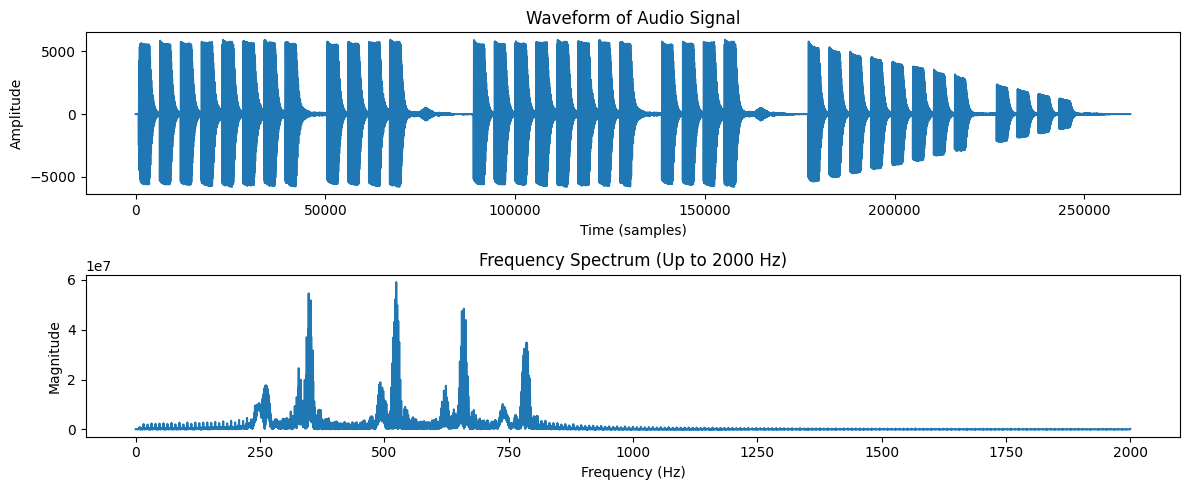

In [166]:
for i in range (0,N):
    if np.abs(fft_result[i]) < 10000:
        fft_result[i] = 0

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(audio_segment)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum (Up to 2000 Hz)")
plt.tight_layout()
plt.show()



In [167]:
filtered_audio = np.int16(ifft(fft_result).real) 

output_filename = "filtered_audio.wav"
write(output_filename, sample_rate, filtered_audio)

In [168]:
fft_result = fft(filtered_audio)
frequencies = np.fft.fftfreq(N, d=1/sample_rate)

# Retune ratio (A440 to A415)
retune_ratio = 440/415

# New frequency bins after shifting
shifted_frequencies = frequencies * retune_ratio

# Interpolate FFT result to match new frequency bins
interp_func = interp1d(frequencies, fft_result, kind='linear', fill_value=0, bounds_error=False)
shifted_fft_result = interp_func(shifted_frequencies)


for i in range (0,N):
    if np.abs(shifted_fft_result[i]) < 1000:
        shifted_fft_result[i] = 0


retuned_audio = np.int16(ifft(shifted_fft_result).real)


output_filename = "retuned_audio.wav"
write(output_filename, sample_rate, retuned_audio)

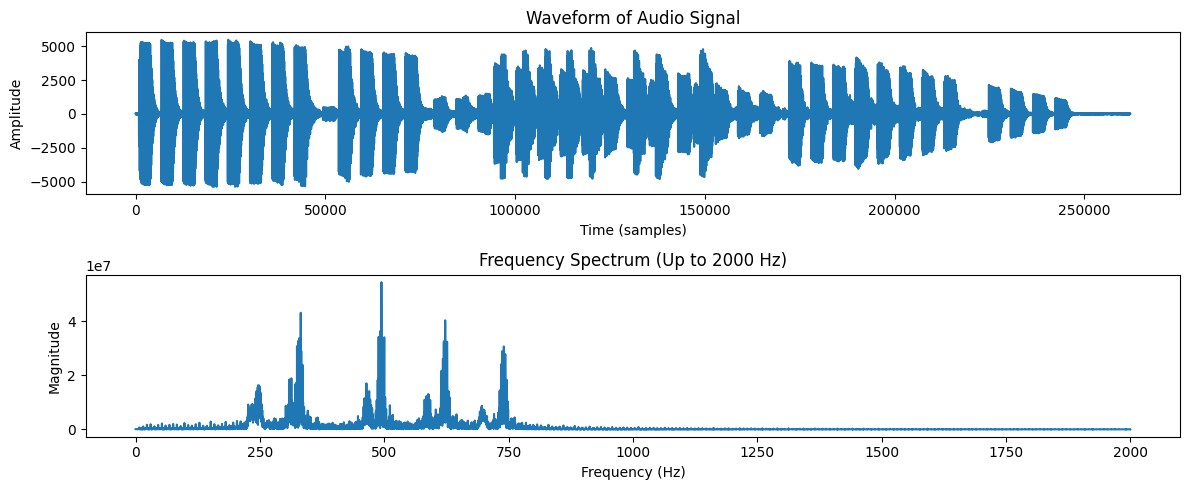

In [170]:
max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(retuned_audio)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(shifted_fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum (Up to 2000 Hz)")
plt.tight_layout()
plt.show()
